In [328]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import networkx as nx
import matplotlib.pyplot as plt

In [329]:
# Load dataset
data = pd.read_csv('titanic_data.csv')
data['Pclass'] = data['Pclass'] - 1
features = [Str for Str in data.columns]
Data = [data[LIST].tolist() for LIST in features]

In [330]:
# One-Hot Encoding
OneHotEncoderLIST = [0] * 7
# CATEGORICAL_FEATURES 
N = len(Data[0])
for index in [0, 1, 2, 4, 5]:
    OneHotEncoder = np.identity(max(Data[index]) - min(Data[index]) + 1)
    OneHotEncoderLIST[index] = OneHotEncoder
    for i in range(N):
        Data[index][i] = OneHotEncoder[Data[index][i]]
# NUMERICAL_FEATURES 
# Age binning
OneHotEncoder = np.identity(7)
OneHotEncoderLIST[3] = OneHotEncoder
bins = np.linspace(0, 100, 9)
for i in range(N):
    Data[3][i] = OneHotEncoder[np.digitize(Data[3][i], bins) - 1]
# Fare binning
OneHotEncoder = np.identity(20)
OneHotEncoderLIST[6] = OneHotEncoder
bins = np.linspace(0, 600, 21)
for i in range(N):
    Data[6][i] = OneHotEncoder[np.digitize(Data[6][i], bins) - 1]

In [331]:
def One_Hot_Encode(x, OneHotEncoderLIST):
    for index in [1, 2, 4, 5]:
        x[index-1] = OneHotEncoderLIST[index][x[index-1]]
    bins = np.linspace(0, 100, 9)
    x[2] = OneHotEncoderLIST[3][np.digitize(x[2], bins) - 1]
    bins = np.linspace(0, 600, 21)
    x[5] = OneHotEncoderLIST[6][np.digitize(x[5], bins) - 1]
    return x
x = [[data[LIST].tolist() for LIST in features][i][0] for i in range(1,7)]
One_Hot_Encode(x, OneHotEncoderLIST)

[array([0., 0., 1.]),
 array([1., 0.]),
 array([0., 1., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])]

In [332]:
# Entropy
def Entropy(INDEX, DATA):
    if len(DATA[INDEX]) < 1:
        return 0
    vals = len(DATA[INDEX][0])
    SUM = len(DATA[INDEX])
    Sum = np.zeros(vals)
    for x in DATA[INDEX]:
        Sum = Sum + x
#     print(Sum)
    ans = 0
    for i in range(vals):
        Pr = Sum[i] / SUM
        if Pr <= 0:
            continue
        ans = ans - Pr * math.log(Pr)
    return ans
Entropy(1, Data)

0.9994651137627315

In [273]:
# Split Data
def Split(INDEX, val, DATA):
    N = len(DATA[INDEX])
    index_set = [i for i in range(N) if DATA[INDEX][i][val] == 1]
    New_data = []
    for feature_index in range(7):
        New_data.append([DATA[feature_index][i] for i in index_set])
    return New_data

In [333]:
# Conditional Entropy
def H(INDEX1, INDEX2, DATA):
    if len(DATA[INDEX2]) < 1:
        return 0
    SUM = len(DATA[INDEX2])
    ans = 0
    for y in range(len(DATA[INDEX2][0])):
        for x in range(len(DATA[INDEX1][0])):
            Pr1 = len([i for i in range(SUM) if DATA[INDEX1][i][x] == 1 and DATA[INDEX2][i][y] == 1])
            Pr2 = len([i for i in range(SUM) if DATA[INDEX2][i][y] == 1])
            if Pr1 == 0:
                continue
            Pr = Pr1 / Pr2
            ans = ans - (Pr1/SUM) * math.log(Pr)
    return ans
H(1,0,DATA)

0.9420283503592445

In [334]:
# Mutual Information
def I(INDEX1, INDEX2, DATA):
    return Entropy(INDEX1, DATA) - H(INDEX1, INDEX2, DATA)
I(1,0,DATA)

0.05743676340348702

In [276]:
# LIST_Mutual_Information
def LIST_Mutual_Information(DATA):
    feature_count = len(DATA) - 1
    LIST = [I(feature, 0, DATA) for feature in range(1, feature_count+1)]
    return LIST

In [277]:
# Tree Struct
class Node:
    def __init__(self, feature_index, Depth = 0, value = None):
        FEATURE_LIST = [Str for Str in data.columns]
        self.feature_index = feature_index
        self.feature_name = FEATURE_LIST[feature_index]
        self.pre_feature_val = value
        self.child = []
        self.leaf = 0
        self.predict = 0
        self.depth = Depth

In [282]:
# Build Decision Tree
def Build(DATA, Depth = 0, value = None, epsilon = 1e-2, alpha = 0.05):
    if len(DATA[0]) < alpha * len(Data[0]):
        LEAF = Node(0, Depth, value)
        LEAF.leaf = 1
        LEAF.predict = np.argmax(sum(DATA[0]))
        print("LEAF: DATA_SIZE:", len(DATA[0]))
        return LEAF
    if Entropy(0, DATA) < epsilon:
        LEAF = Node(0, Depth, value)
        LEAF.leaf = 1
        LEAF.predict = np.argmax(sum(DATA[0]))
        print("LEAF: Entropy:", Entropy(0, DATA))
        return LEAF
    if Depth == len(features) - 2:
        LEAF = Node(0, Depth, value)
        LEAF.leaf = 1
        LEAF.predict = np.argmax(sum(DATA[0]))
        print("LEAF: Depth:", Depth)
        return LEAF
    
    Mutual_Information_list = LIST_Mutual_Information(DATA)
    MAX = max(Mutual_Information_list)
    Select_feature_index = Mutual_Information_list.index(MAX) + 1
    
    print(Mutual_Information_list)
    print(features[Select_feature_index])

    node = Node(Select_feature_index, Depth, value)
    vals = len(DATA[Select_feature_index][0])
    for val in range(vals):
        New_data = Split(Select_feature_index, val, DATA)
        node.child.append(Build(New_data, Depth+1, val))
    return node
Decision_Tree = Build(Data)

[0.05743676340348702, 0.15030862287961178, 0.010270810809761999, 0.02303030151917762, 0.01615517194666083, 0.04079119379306062]
Sex
[0.02516734405144494, 0.0, 0.04505292570707109, 0.01422409086772125, 0.01108124432876001, 0.030165833563874478]
Age
LEAF: DATA_SIZE: 41
[0.004337567480908633, 0.0, 0.0, 0.004592121632349122, 0.003208755641778749, 0.012008966223218565]
Fare
[6.007214144787554e-06, 0.0, 0.0, 0.002989086902971949, 0.0006243392717450724, 0.0]
Siblings/Spouses Aboard
[0.00026637361669273885, 0.0, 0.0, 0.0, 0.0, 0.0]
Pclass
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 20
LEAF: Depth: 5
LEAF: DATA_SIZE: 15
LEAF: DATA_SIZE: 5
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 7
LEAF: DATA_SIZE: 10
LEAF: DATA_SIZE: 2
LEAF: DATA_SIZE: 1
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 2
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DATA_SIZE: 0
LEAF: DA

In [284]:
for SubTree in Decision_Tree.child:
    print(SubTree.feature_name)

Age
Pclass


In [285]:
# Print Tree
def PRINT_TREE(Tree, INDENT = 0, VALUE = ''):
    Indent = '-> '
    for i in range(INDENT):
        Indent = '\t' + Indent
    if Tree.leaf == 1:
        VALUE = str(Tree.pre_feature_val)
        if Tree.predict == 0:
            Survived = 'False'
        else:
            Survived = 'True'
        print(Indent+VALUE+'='+Survived)
        return
    print(Indent+VALUE+'-'+Tree.feature_name)
    for SubTree in Tree.child:
        VALUE = str(SubTree.pre_feature_val)
        PRINT_TREE(SubTree,INDENT+1,VALUE)
    return
PRINT_TREE(Decision_Tree)

-> -Sex
	-> 0-Age
		-> 0=True
		-> 1-Fare
			-> 0-Siblings/Spouses Aboard
				-> 0-Pclass
					-> 0=False
					-> 1=False
					-> 2=False
				-> 1=False
				-> 2=False
				-> 3=False
				-> 4=False
				-> 5=False
				-> 6=False
				-> 7=False
				-> 8=False
			-> 1=False
			-> 2=False
			-> 3=False
			-> 4=False
			-> 5=False
			-> 6=False
			-> 7=False
			-> 8=False
			-> 9=False
			-> 10=False
			-> 11=False
			-> 12=False
			-> 13=False
			-> 14=False
			-> 15=False
			-> 16=False
			-> 17=False
			-> 18=False
			-> 19=False
		-> 2-Pclass
			-> 0=True
			-> 1-Parents/Children Aboard
				-> 0=False
				-> 1=False
				-> 2=False
				-> 3=False
				-> 4=False
				-> 5=False
				-> 6=False
			-> 2-Fare
				-> 0-Siblings/Spouses Aboard
					-> 0=False
					-> 1=False
					-> 2=False
					-> 3=False
					-> 4=False
					-> 5=False
					-> 6=False
					-> 7=False
					-> 8=False
				-> 1=True
				-> 2=False
				-> 3=False
				-> 4=False
				-> 5=False
				-> 6=False
				-> 7=False
				-> 8

In [299]:
# Predict
def Predict(x, Tree):
    x = One_Hot_Encode(x, OneHotEncoderLIST)
    Point = Tree
    FEATURE_INDEX = Point.feature_index
    FEATURE_NAME = Point.feature_name
    
    while Point.leaf == 0:
        for index in Point.child:
            if x[FEATURE_INDEX-1].tolist().index(1) == index.pre_feature_val:
                NEXT = index
                break
        Point = NEXT
#         print(Point.feature_name)
    return Point.predict

ans = 0
for i in range(data.count()[0]):
    x = [[data[LIST].tolist() for LIST in features][i][4] for i in range(1,7)]
    ans = ans + Data[0][i].tolist().index(1) - Predict(x, Decision_Tree)
ans

-545

In [314]:
Data = data.drop(['Survived'], axis=1).values
y_label = data['Survived'].values

In [317]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(Data, y_label)

[Text(200.65961643586007, 212.49818181818182, 'X[1] <= 0.5\ngini = 0.474\nsamples = 887\nvalue = [545, 342]'),
 Text(117.42859876093294, 202.61454545454546, 'X[2] <= 13.0\ngini = 0.308\nsamples = 573\nvalue = [464, 109]'),
 Text(78.178972303207, 192.73090909090908, 'X[3] <= 2.5\ngini = 0.493\nsamples = 41\nvalue = [18, 23]'),
 Text(74.27459912536443, 182.84727272727272, 'X[4] <= 0.5\ngini = 0.083\nsamples = 23\nvalue = [1, 22]'),
 Text(72.32241253644315, 172.96363636363637, 'X[2] <= 11.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(70.37022594752187, 163.07999999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(74.27459912536443, 163.07999999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(76.22678571428571, 172.96363636363637, 'gini = 0.0\nsamples = 21\nvalue = [0, 21]'),
 Text(82.08334548104956, 182.84727272727272, 'X[2] <= 3.5\ngini = 0.105\nsamples = 18\nvalue = [17, 1]'),
 Text(80.13115889212828, 172.96363636363637, 'X[2] <= 2.5\ngini = 0.278\nsamples = 6\nva

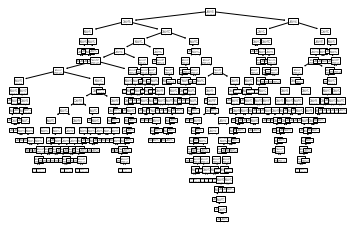

In [326]:
tree.plot_tree(clf)

In [324]:
ans = 0
for i in range(data.count()[0]):
    ans = ans +  y_label[i] - clf.predict([Data[i]])
ans

array([16], dtype=int64)